One interest question is: What are the features in the images the model is learning?
to answer this question we can make use of this tool https://github.com/raghakot/keras-vis
In this notebook i'm using the salience and attention map to check what is going on in different models I'm testing.

In [1]:
#import some of the stuff I need
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from time import time
import cv2
from pylab import rcParams
import json
from functions import * #I'm going to use very nice functions inside this .py
%matplotlib inline

Using TensorFlow backend.


In [3]:
# load json models we created before.
from keras.models import model_from_json
json_file = open('VGG16_convmap_2class.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 3, 3, 16)          32784     
_________________________________________________________________
flatten_1 (Flatten)          (None, 144)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                9280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 14,756,882
Trainable params: 7,121,618
Non-trainable params: 7,635,264
_________________________________________________________

In [4]:
#Load the pre trained weights, local or at the Sussex HPC
loaded_model.load_weights('weights_VGG16_03-0.52.hdf5')

In [5]:
# Get desired feature map (2nd convolutive layer)
loaded_model.layers

In [6]:
# Load npz file containing image arrays
x_npz = np.load("x_Pneumothorax_balanced_128.npz")
x = x_npz['arr_0']
# Load binary encoded labels for Lung Infiltrations: 0=disiese not found 1=disiese found
y_npz = np.load("y_Pneumothorax_balanced_128.npz")
y = y_npz['arr_0']

In [7]:
# First split the data in two sets, 80% for training, 20% for Val/Test)
X_train, X_valtest, y_train, y_valtest = train_test_split(x,y, test_size=0.2, random_state=1, stratify=y)

# Second split the 20% into validation and test sets
X_test, X_val, y_test, y_val = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=1, stratify=y_valtest)

In [9]:
# I'm using the categorical cross entropy as loss function,
#so we need to convert our labels streming into a category list
nb_categories = 2

from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train,nb_categories)
y_test = np_utils.to_categorical(y_test,nb_categories)
y_valtest = np_utils.to_categorical(y_valtest,nb_categories)
y_val = np_utils.to_categorical(y_val,nb_categories)

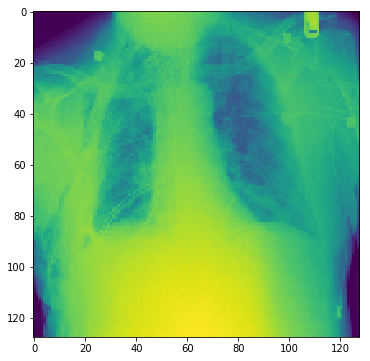

In [10]:
#Plot some images from our numpy data array, in this case we are ploting the health images.
class_idx = 0
indices = np.where(y_test[:, class_idx] == 0.)[0]

# pick some random input from here.
idx = indices[0]

# Lets sanity check the picked image.
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

plt.imshow(X_test[idx][..., 0])

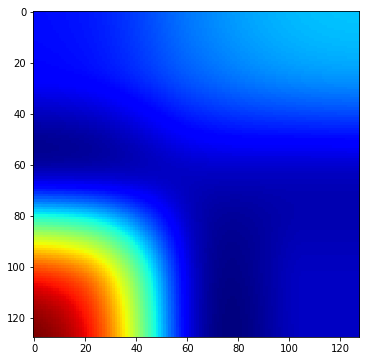

In [12]:
from vis.visualization import visualize_saliency, visualize_cam
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(loaded_model, 'dense_2')

# Swap softmax with linear
loaded_model.layers[layer_idx].activation = activations.linear
loaded_model = utils.apply_modifications(loaded_model)

grads = visualize_cam(loaded_model, layer_idx, filter_indices=0, seed_input=X_test[idx])
# Plot with 'jet' colormap to visualize as a heatmap.
plt.imshow(grads, cmap='jet')

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


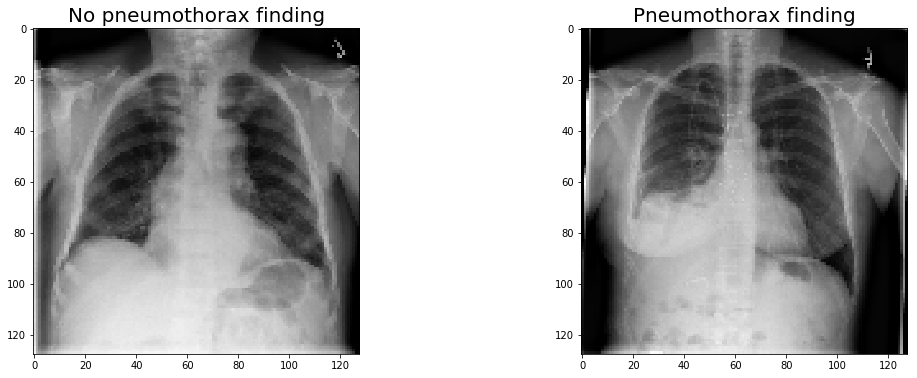

In [13]:
#Select the seed Images for the layers visualization
from vis.utils import utils
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

img1 = utils.load_img('img/no_findings/00000011_002.png', target_size=(X_train.shape[1],X_train.shape[2]))
img2 = utils.load_img('img/pneumothorax_img/00008841_020.png', target_size=(X_train.shape[1],X_train.shape[2]))


f, ax = plt.subplots(1, 2)
ax[0].imshow(img1)
ax[0].set_title("No pneumothorax finding",fontsize=20)
ax[1].imshow(img2)
ax[1].set_title("Pneumothorax finding",fontsize=20)
#f.savefig('seed_image.pdf')

# Create the Salience maps using our seed images.

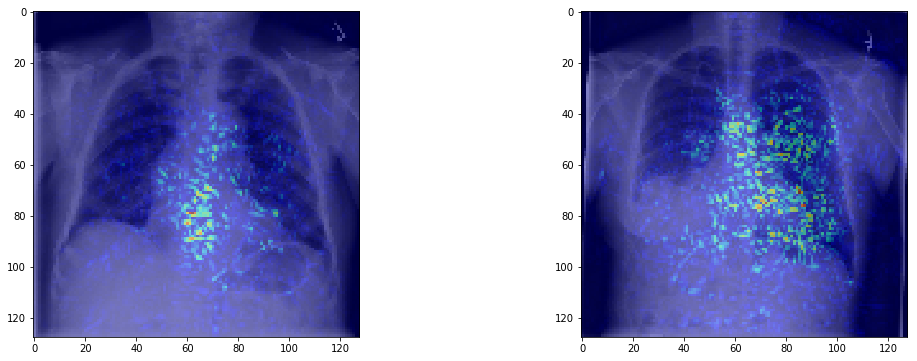

In [14]:

from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(loaded_model, 'dense_2')

f, ax = plt.subplots(1, 2)
for i, img in enumerate([img1, img2]):    
    # 20 is the imagenet index corresponding to `ouzel`
    grads = visualize_saliency(loaded_model, layer_idx, filter_indices=0, seed_input=img)
    
    # visualize grads as heatmap
    ax[i].imshow(overlay(grads,img), cmap='jet')


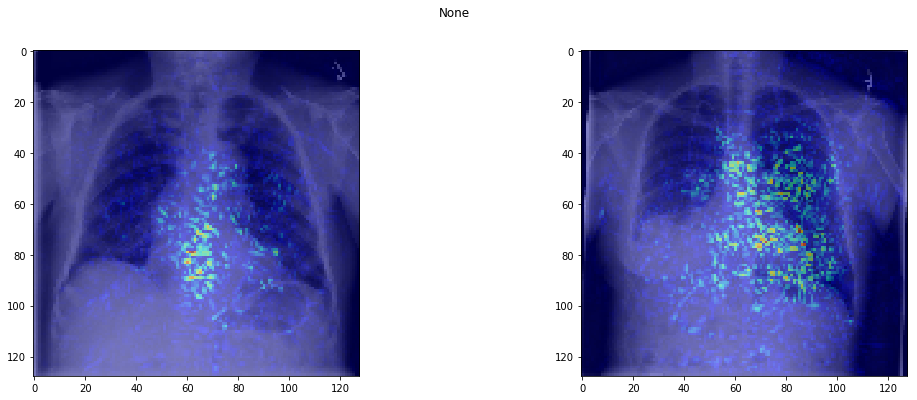

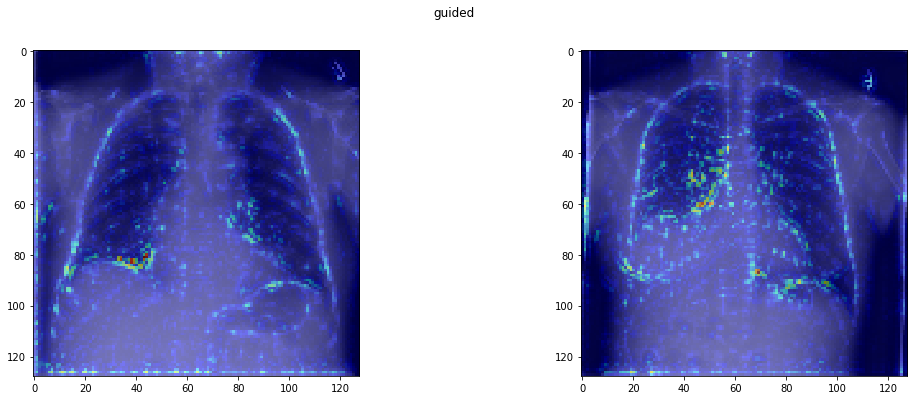

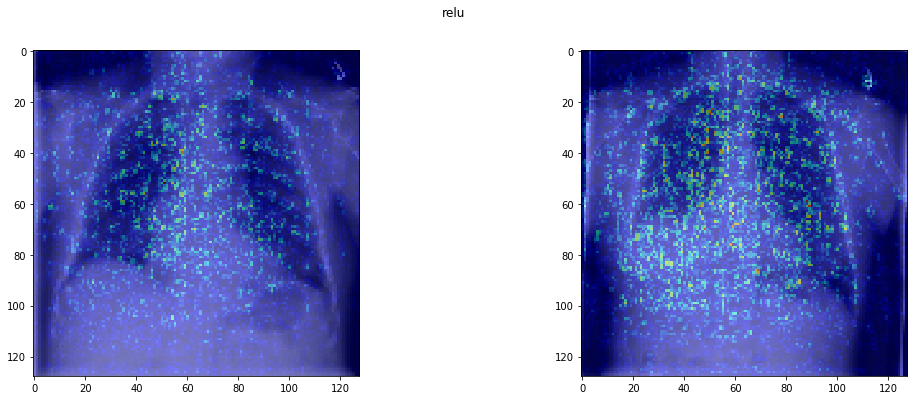

In [16]:
#check differents activations in the classifier layer.
for modifier in [None,'guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle(modifier)
    for i, img in enumerate([img1, img2]):    
        grads = visualize_saliency(loaded_model, layer_idx, filter_indices=0,
                                   seed_input=img, backprop_modifier=modifier)
        ax[i].imshow(overlay(grads,img), cmap='jet')


# Create the attention maps using our seed images.

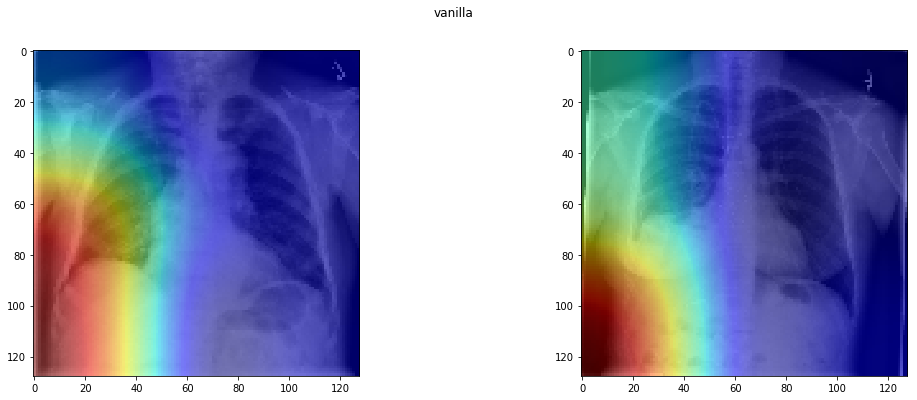

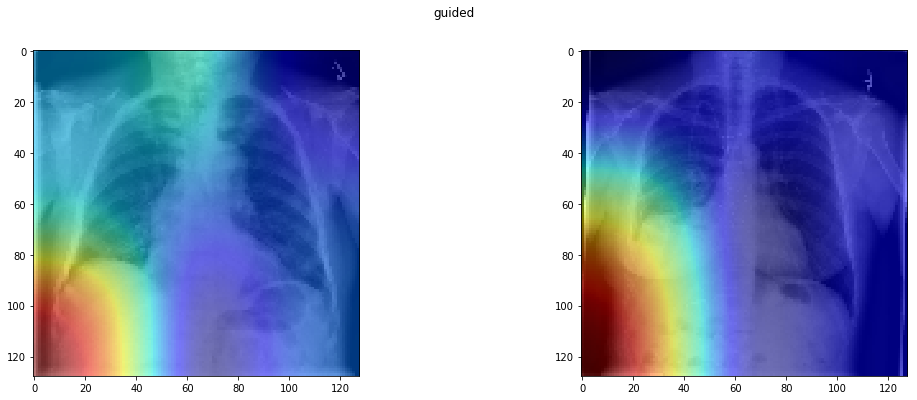

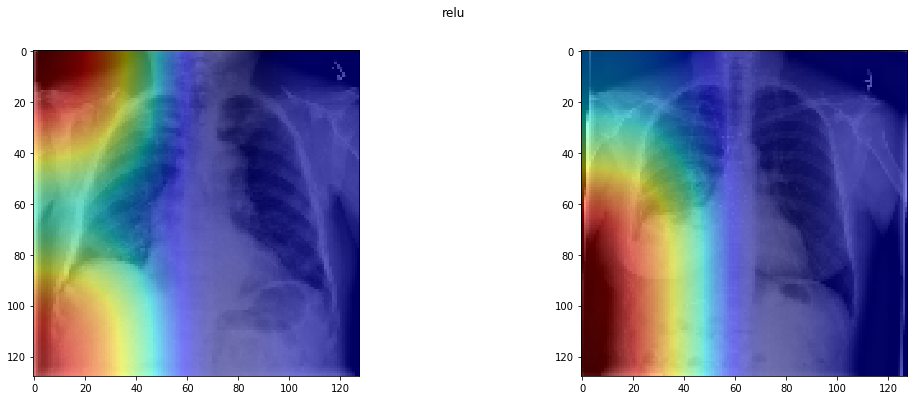

In [17]:
#check differents activations in the classifier layer.

import numpy as np
import matplotlib.cm as cm
from vis.visualization import visualize_cam

for modifier in [None, 'guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([img1, img2]):    
        # 20 is the imagenet index corresponding to `ouzel`
        grads = visualize_cam(loaded_model, layer_idx, filter_indices=0, 
                              seed_input=img, backprop_modifier=modifier)        
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        ax[i].imshow(overlay(grads, img))

In [11]:
layer_idx = utils.find_layer_idx(loaded_model, 'classificator')

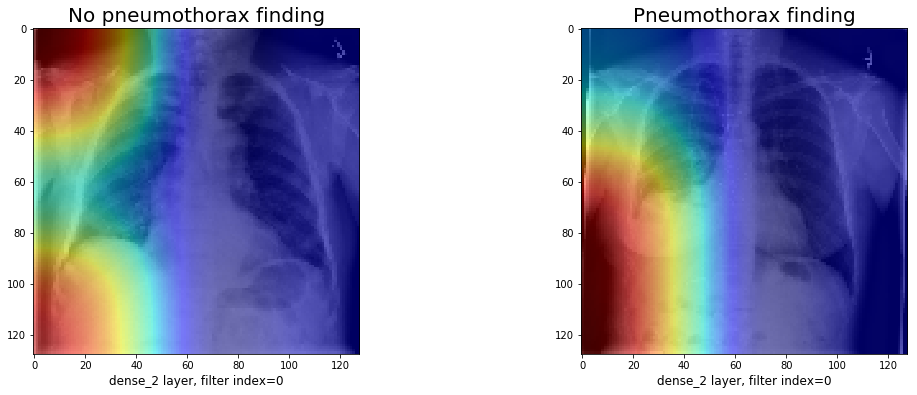

In [21]:
# create the plots with the attention maps
f, ax = plt.subplots(1, 2)
fi = 0
grad_health = visualize_cam(loaded_model, layer_idx, filter_indices=fi, seed_input=img1, backprop_modifier='relu')        
grad_pneumo = visualize_cam(loaded_model, layer_idx, filter_indices=fi, seed_input=img2, backprop_modifier='relu')
ax[0].imshow(overlay(grad_health, img1))
ax[0].set_title("No pneumothorax finding",fontsize=20)
ax[0].set_xlabel("{} layer, filter index={}".format(loaded_model.layers[layer_idx].name, fi), fontsize=12)
ax[1].imshow(overlay(grad_pneumo, img2))
ax[1].set_title("Pneumothorax finding",fontsize=20)
ax[1].set_xlabel("{} layer, filter index={}".format(loaded_model.layers[layer_idx].name, fi), fontsize=12)
#Save my images with a more convinient names!!
f.savefig('figs/visual_cam_pneumothorax_{}_{}_{}_{}.pdf'.format(loaded_model.layers[layer_idx].name,fi,len(loaded_model.layers),X_train.shape[1]))

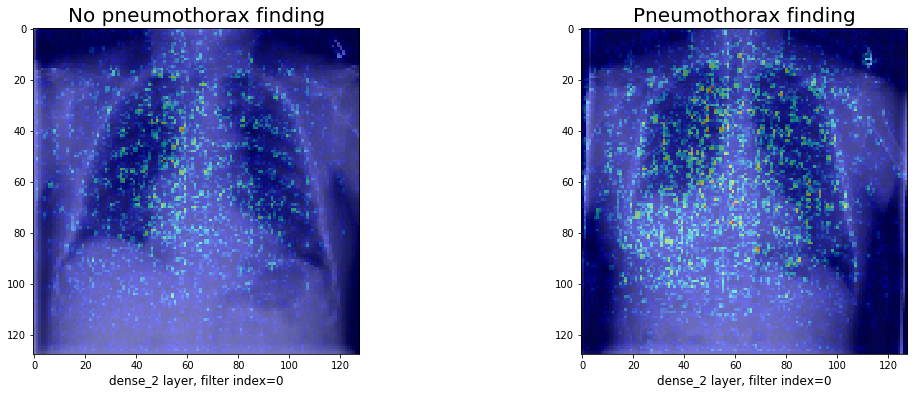

In [22]:
## create the plot with the saliences to save.
f, ax = plt.subplots(1, 2)
fi = 0
grad_health = visualize_saliency(loaded_model, layer_idx, filter_indices=fi, seed_input=img1, backprop_modifier='relu')        
grad_pneumo = visualize_saliency(loaded_model, layer_idx, filter_indices=fi, seed_input=img2, backprop_modifier='relu')
ax[0].imshow(overlay(grad_health, img1))
ax[0].set_title("No pneumothorax finding",fontsize=20)
ax[0].set_xlabel("{} layer, filter index={}".format(loaded_model.layers[layer_idx].name, fi), fontsize=12)
ax[1].imshow(overlay(grad_pneumo, img2))
ax[1].set_title("Pneumothorax finding",fontsize=20)
ax[1].set_xlabel("{} layer, filter index={}".format(loaded_model.layers[layer_idx].name, fi), fontsize=12)
#Save my images with a more convinient names!!
f.savefig('figs/visual_salience_pneumothorax_{}_{}_{}_{}.pdf'.format(loaded_model.layers[layer_idx].name,fi,len(loaded_model.layers),X_train.shape[1]))